### Many-body Entanglement and Tensor Networks
Tutorials based on the 2017 Perimeter Scholar International Condensed Matter Review course taught by Guifre Vidal

# <span style="color:#0C45A9">Python tutorial 6</span>

In this tutorial we will work within the free Majorana fermion formalism.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig

import warnings
warnings.filterwarnings('ignore')

## 6.1. Free Majorana system: energy

This is a system of $2N$ Majorana modes. The algebra is:
<center> $\psi_I \;,\; I \equiv(n,\alpha)\quad\text{with}\; n=1,2,...,N\;\;\text{and}\;\;\alpha=1,2\;,$ <br>
<p align="left">where $n$ is used to denote the pair and $\alpha$ to refer to the mode within each pair. <br>
These operators also obey hermitianity and anticommutativity:
<center> $\psi_I^{\dagger}=\psi_I\;,\; \{\psi_I,\psi_J\}=\delta_{IJ}$.<br>
<br>
<p align="left">We aim to simultaneously diagonalise the Hamiltonian (given by matrix $C$) and the translation operator ($T$).</p>
<br>
<center> $C \left\vert \psi_m \right \rangle = e_m\left\vert \psi_m \right \rangle  $ <center> 
    <br>
<center> $T \left\vert \psi_m \right \rangle = e^{ik_m}\left\vert \psi_m \right \rangle  $ <center>
    <br>
<p align="left">This will give us an eigenbasis of size $N$:
<center> $\{e_m\}, \{k_m\}$  where  $m=1,...,N$ <center> 
<br>
 <p align="left">Which can be mapped back to our $2^N$ basis:
<center> $\{E_{\alpha}\}, \{K_{\alpha}\}$  where  ${\alpha}=1,...,2^N$ <center> 
<br>

### 6.1.1. Functions for Hamiltonian and Translation operators

#### a) Building $2N\times2N$ Hamiltonian matrix $C$

In [2]:
def build_matrix_C(N, h, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    Z = np.zeros((2*N,2*N)) # number operator
    J = np.zeros((2*N,2*N)) 
    for i in range(N):
        Z[2*i,2*i:2*i+2] = [0, 2*h]
        Z[2*i+1,2*i:2*i+2] = [-2*h, 0]
    
    for i in range(N-1):
        J[2*i+1,2*i+2] = 2
        J[2*i+2,2*i+1] = -2

    J[0, 2*N-1] = -2*bc
    J[2*N-1, 0] = 2*bc
    
    C = Z+J
    return C

#### b) Building translation operator $T_f$

In [3]:
def build_T_operator(N, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    T_op = np.zeros((2*N,2*N))
    for i in range(2*N-2):
        T_op[i,i+2] = 1
        
    T_op[2*N-2,0] = bc
    T_op[2*N-1,1] = bc
    return T_op

### 6.1.2. Single particle system: diagonalization of  $C$ and $T$.

We obtain the single particle energies $e_\alpha$ and momenta $k_{\alpha}$.

In [4]:
def diagonalise_C_T(C, T_op):
    N = int(np.shape(C)[0]/2)
    M = C.dot(np.eye(2*N) + 0.13*T_op)
    D, U = eig(M)
    
    e = np.real(np.diag((1j*U.conj().T).dot(C).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    #sort from smaller to largest
    ord_idx = np.argsort(e)
    e = e[ord_idx]
    k = k[ord_idx]
    
    #remove negative side of spectrum
    e = e[e > 0]
    rem = len(e)
    k = k[-rem::]
    
    return e, k

In [5]:
N = 500
h = 1 # critical

#PERIODIC BC
C_pbc = build_matrix_C(N, h, bc = 1)
T_pbc = build_T_operator(N, bc = 1)
e_pbc, k_pbc = diagonalise_C_T(C_pbc, T_pbc)
#ANTIPERIODIC BC
C_apbc = build_matrix_C(N, h, bc = -1)
T_apbc = build_T_operator(N, bc = -1)
e_apbc, k_apbc = diagonalise_C_T(C_apbc, T_apbc)

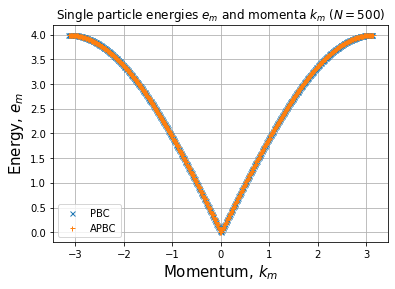

In [6]:
plt.title("Single particle energies $e_m$ and momenta $k_m$ ($N=$%s)" %(N))
plt.grid()
plt.ylabel(r"Energy, $e_m$", fontsize = 15)
plt.xlabel(r"Momentum, $k_m$", fontsize = 15)
plt.plot(k_pbc, e_pbc, 'x', ms=5, label = 'PBC')
plt.plot(k_apbc, e_apbc, '+', ms=5, label = 'APBC')
plt.legend()
plt.show()

### 6.1.3. Multi-particle system: energies and momenta

Since our multi-particle system is composed of decoupled modes, the energy of the total system is:
<center> $E_{\vec{x}} = \sum_m (-1)^{x_m}e_m \quad$ and $\quad K_{\vec{x}} = \sum_m (-1)^{x_m}k_m \quad$ where $\quad\vec{x}=(0,1,1,0,\cdots)$.

In [7]:
def configurations(n, fN):
    """
    Generates the configurations $\vec{x}.
     n = configuration number
     fN = size to pad to
    """
    conf_int = bin(n).replace("0b", "")
    conf_list = [int(i) for i in conf_int]
    conf_list = conf_list[::-1]
    fill_list = [0 for i in range(fN-len(conf_list))]
    conf_list += fill_list
    return conf_list

In [8]:
def multi_part_E(e, k , fN): #fN first N single particle states in which to expand the multi-particle system
    N = len(e)
    if fN > N:
        fN = N #can't expand in more modes than available
    
    E = -np.ones((2**fN))*(np.sum(e)/2)
    K = np.zeros(2**fN)
    p = np.zeros(2**fN) #parity
    
    for n in range(2**fN-2):
        x = configurations(n, fN)
        for m in range(fN):
            E[n] += x[m]*e[m]
            K[n] += x[m]*k[m]
            p[n] = np.sum(x)%2
    ord_idx = np.argsort(E)
    E = E[ord_idx]
    K = K[ord_idx]
    p = p[ord_idx]
    
    return E, K, p

In [9]:
fN = 10

E_pbc, K_pbc, p_pbc = multi_part_E(e_pbc, k_pbc, fN)
K_pbc = (K_pbc+np.pi+0.001)%(2*np.pi)-(np.pi+0.001) #Brillouin zone

E_apbc, K_apbc, p_apbc = multi_part_E(e_apbc, k_apbc, fN)
K_apbc = (K_apbc+np.pi+0.001)%(2*np.pi)-(np.pi+0.001) #Brillouin zone

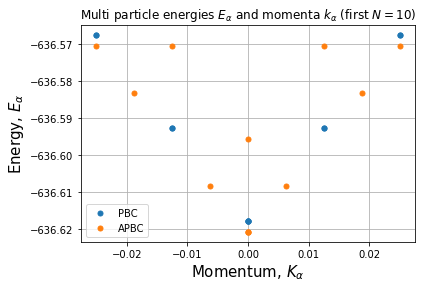

In [10]:
plt.title(r"Multi particle energies $E_{\alpha}$ and momenta $k_{\alpha}$ (first $N=$%s)" %(fN))
plt.grid()
plt.ylabel(r"Energy, $E_{\alpha}$", fontsize = 15)
plt.xlabel(r"Momentum, $K_{\alpha}$", fontsize = 15)
first = 12
plt.plot(K_pbc[0:first], E_pbc[0:first], 'o', ms=5, label = 'PBC')
plt.plot(K_apbc[0:first], E_apbc[0:first], 'o', ms=5, label = 'APBC')
plt.legend()
plt.show()

In [11]:
print("CHECK: energy density (%s) should be close to -4/pi (%s)" %(np.round(E_apbc[0]/N,4), np.round(-4/np.pi,4)))

CHECK: energy density (-1.2732) should be close to -4/pi (-1.2732)


### 6.1.4. Multi-particle system: conformal data

It is true for any CFT that $\Delta_0 = S_0 = 0$ and $\Delta_T = S_T = 2$ (corresponding to stress-energy tensor). <br>
We can also use the relation: ${\Delta_{\alpha} = (\Delta_T-\Delta_0)\frac{E_{\alpha}-E_0}{E_T-E_0}+\Delta_0} = 2\frac{E_{\alpha}-E_0}{E_T-E_0}$ to find the resting scaling dimensions

In [12]:
k_T = 4*np.pi/N

#obtain the eigenstate number corresponding to k_T to obtain E_T
N_T = 0
for n in range(len(K_apbc)):
    if abs(K_apbc[n]-k_T) < 1e-4:
        if N_T == 0:
            N_T = n
print("Stress-energy tensor eigenvalue number:", N_T)

Stress-energy tensor eigenvalue number: 10


#### Scaling dimension and conformal spin

Periodic Boundary Conditions

In [13]:
#re-scale using APBC energy
scaling_dim_pbc = (E_pbc-E_apbc[0])/(E_apbc[5]-E_apbc[0])
conf_spin_pbc = K_pbc/(2*np.pi)*N
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim_pbc, conf_spin_pbc))

Scaling dimension: [ 0.12500031  0.12500031  0.12500031 ... 24.12290802 24.12290802
 24.12290802] 
Conformal spin: [0. 0. 0. ... 4. 6. 6.]


A-periodic Boundary Conditions

In [14]:
scaling_dim_apbc = 2*(E_apbc-E_apbc[0])/(E_apbc[N_T]-E_apbc[0])
conf_spin_apbc = K_apbc/(2*np.pi)*N
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim_apbc, conf_spin_apbc))

Scaling dimension: [ 0.          0.          0.         ... 23.4982778  23.99826299
 24.49826793] 
Conformal spin: [ 0.   0.   0.  ...  1.5  0.  -0.5]


#### Plotting

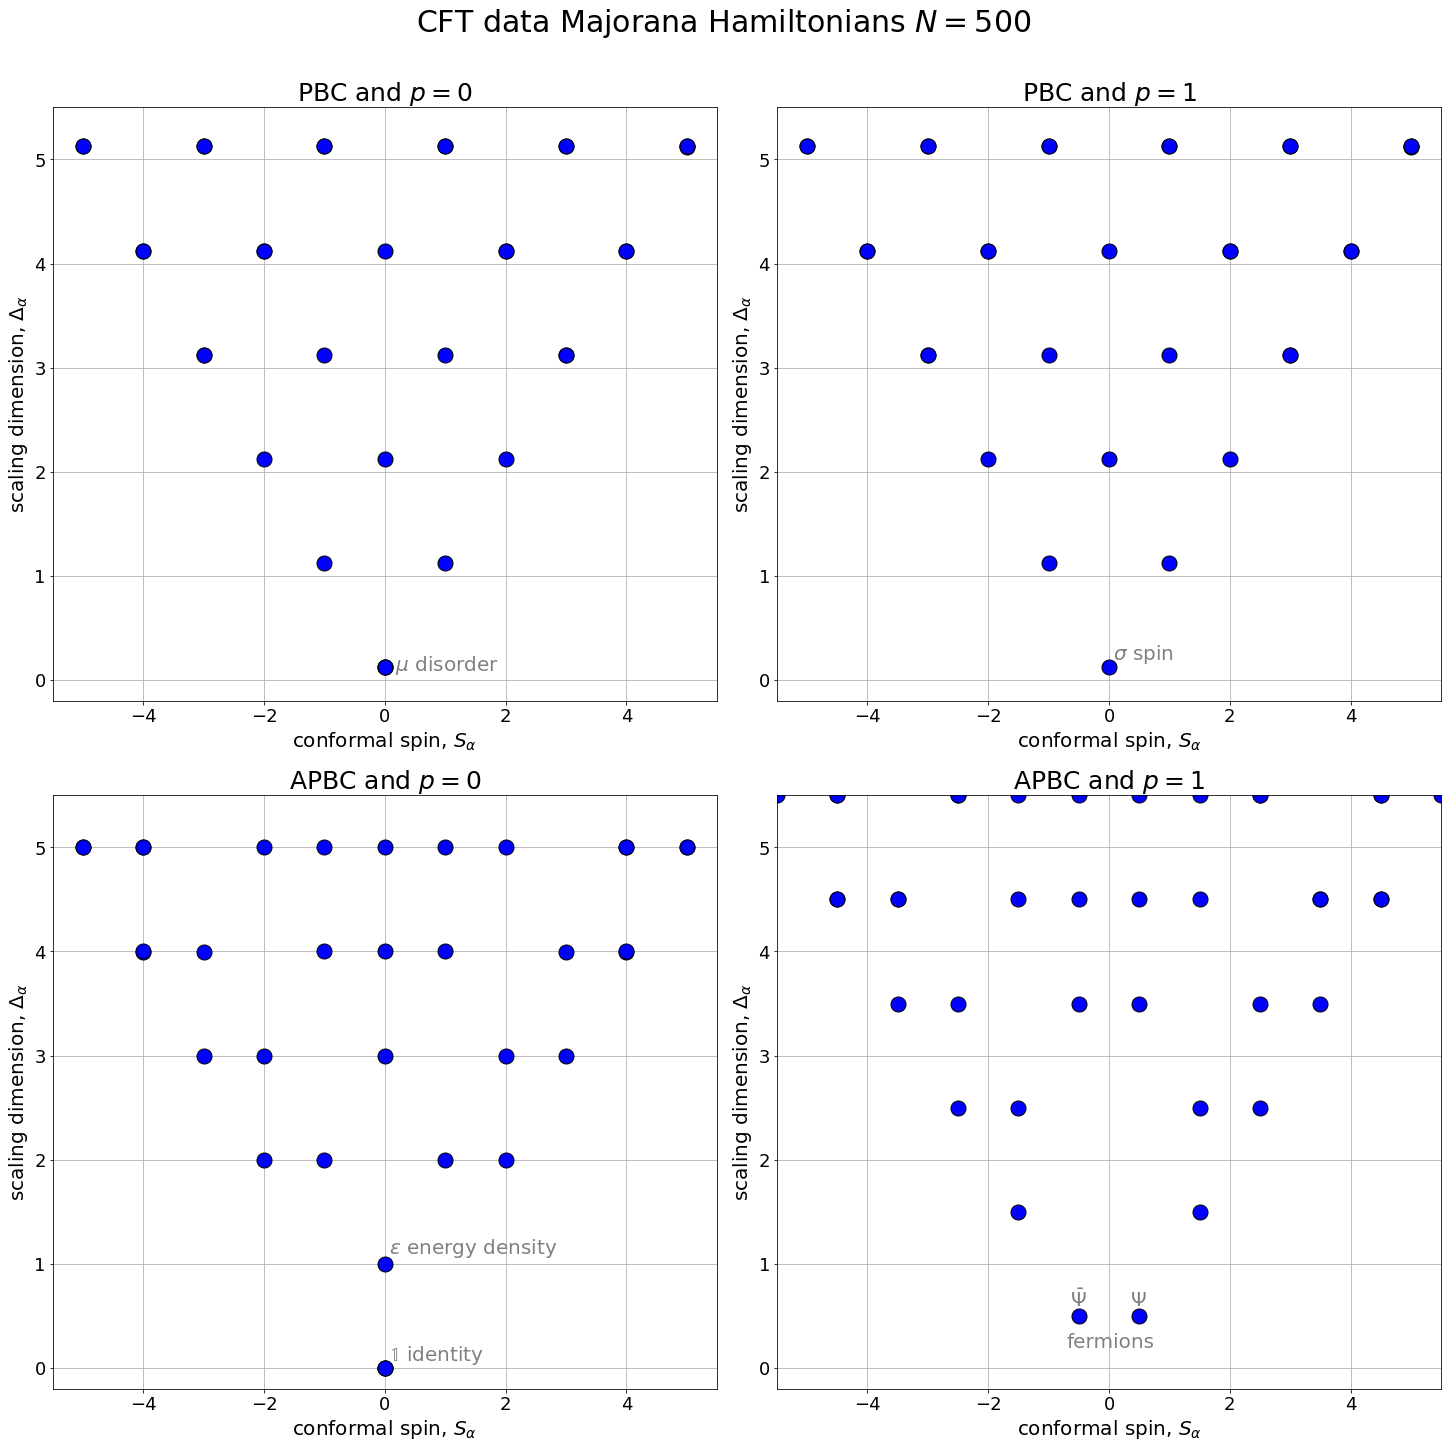

In [15]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained", figsize=(20, 20) )
fig.suptitle(r'CFT data Majorana Hamiltonians $N=500$'+' \n', fontsize=30)
ax1.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax2.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax3.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax4.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)

ax1.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax2.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax3.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax4.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)

ax1.set_title(r'PBC and $p=0$', fontsize=25)
ax2.set_title(r'PBC and $p=1$', fontsize=25)
ax3.set_title(r'APBC and $p=0$', fontsize=25)
ax4.set_title(r'APBC and $p=1$', fontsize=25)

ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax3.tick_params(axis='both', labelsize=18)
ax4.tick_params(axis='both', labelsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

lim = 5.5
ax1.set_xlim([-lim, lim])
ax1.set_ylim([-0.2, lim])
ax2.set_xlim([-lim, lim])
ax2.set_ylim([-0.2, lim])
ax3.set_xlim([-lim, lim])
ax3.set_ylim([-0.2, lim])
ax4.set_xlim([-lim, lim])
ax4.set_ylim([-0.2, lim])
#annotations
ax3.text(0.07,1.1,r"$\epsilon$ energy density", fontsize=20, color='grey')
ax3.text(0.07,0.07,r"$\mathbb{1}$ identity", fontsize=20, color='grey')
ax2.text(0.07,1/8+0.07,r"$\sigma$ spin", fontsize=20, color='grey')
ax1.text(0.17,0.09,r"$\mu$ disorder", fontsize=20, color='grey')
ax4.text(0.35,0.6,r"$\Psi$", fontsize=20, color='grey')
ax4.text(-0.65,0.6,r"$\bar{\Psi}$", fontsize=20, color='grey')
ax4.text(-0.7,0.2,"fermions", fontsize=20, color='grey')

for i in range(len(p_pbc)):
    if int(p_pbc[i]) == 0:
        ax1.plot(conf_spin_pbc[i], scaling_dim_pbc[i], marker = "o", color = "b", ms=15, markeredgecolor= "black")
    elif int(p_pbc[i]) == 1:
        ax2.plot(conf_spin_pbc[i], scaling_dim_pbc[i], marker = "o", color = "b", ms=15, markeredgecolor= "black")

for i in range(len(p_apbc)):
    if int(p_apbc[i]) == 0:
        ax3.plot(conf_spin_apbc[i], scaling_dim_apbc[i], marker = "o", color = "b", ms=15, markeredgecolor= "black")
    elif int(p_apbc[i]) == 1:
        ax4.plot(conf_spin_apbc[i], scaling_dim_apbc[i], marker = "o", color = "b", ms=15, markeredgecolor= "black")

## 6.2. Free Majorana system: entanglement

### 6.2.1. Correlation matrix $\Gamma$ for ground-state

In [16]:
def obtain_Gamma(C, T_op):
    N = int(np.shape(C)[0]/2)
    M = C.dot(np.eye(2*N) + 0.13*T_op)
    D, U = eig(M)
    
    e = np.real(np.diag((1j*U.conj().T).dot(C).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    G = (-1j*U.dot(np.diag(np.sign(e)))).dot(U.conj().T)
    
    return G

In [17]:
G = obtain_Gamma(C_apbc, T_apbc)

print("Is Gamma successfully real?", np.allclose(G, np.real(G)))
G = np.real(G) #cleaning neglible imaginary part
print("Is Gamma successfully antisymmetric?", np.allclose(G, (G-G.conj().T)/2))

Is Gamma successfully real? True
Is Gamma successfully antisymmetric? True


### 6.2.2. Reduced correlation matrix $\Gamma^A$

In [18]:
L_max = 100
L_s = np.arange(1,L_max+1)

G_A = G[0:2*L_max, 0:2*L_max]

### 6.2.3. Entanglement entropy in ground-state

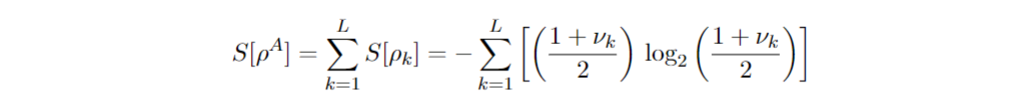

In [19]:
def ent_entropy_majorana(G):
    p = np.shape(G)[0]//2
    entropy = np.zeros(p)
    for n in range(p+1):
        G_red = G[:2*n, :2*n]
        u,v = eig(G_red)
        nu = np.imag(u)
        for m in range(2*n):
            x = nu[m]
            if abs(x) < 1:
                entropy[n-1] -= (1+x)/2*np.log2((1+x)/2)
            elif abs(x) > 1+1e-5:
                print("warning: (absolute) single particle eigenvalue > 1")
    return entropy

In [20]:
entropy_numerical = ent_entropy_majorana(G_A)

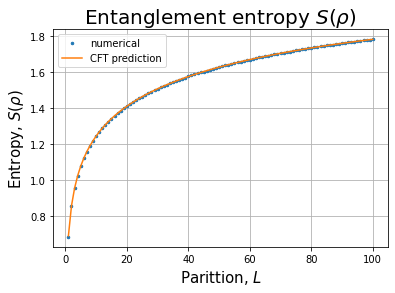

In [21]:
cft_ent_entropy = [1/6*(np.log2(N/np.pi*np.sin(n*np.pi/N))) + 0.69 for n in L_s]
plt.title(r"Entanglement entropy $S(\rho)$", fontsize = 20)
plt.grid()
plt.ylabel(r"Entropy, $S(\rho)$", fontsize = 15)
plt.xlabel(r"Parittion, $L$", fontsize = 15)
plt.plot(L_s, entropy_numerical, '.', ms=5, label = 'numerical')
plt.plot(L_s, cft_ent_entropy, label = 'CFT prediction')
plt.legend()
plt.show()

### 6.2.4. Correlations in ground-state

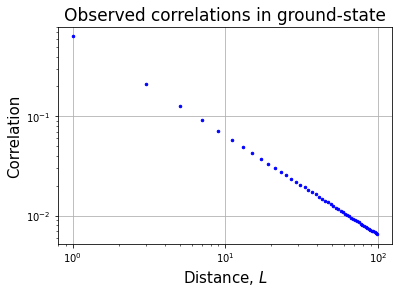

In [22]:
plt.title("Observed correlations in ground-state", fontsize = 17)
plt.grid()
plt.ylabel("Correlation", fontsize = 15)
plt.xlabel(r"Distance, $L$", fontsize = 15)
plt.yscale("log")
plt.xscale("log")
for n in range(L_max+1):
    if np.abs(G[n,0]) > 1e-12:
        if n==L_s[-2]:
            plt.plot(n, np.abs(G[n,0]), '.', ms=5, color = 'blue', label = "numerical")
        else:
            plt.plot(n, np.abs(G[n,0]), '.', ms=5, color = 'blue')
plt.show()